# Naive neural network

In [5]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, cross_entropy_loss_method, predict, accuracy_func_method
from Code.descent_methods import SGD_adam, SGD
from Code.data_handling import load_MNIST_8, load_MNIST_28, append_run_to_file, load_run_from_file
from Code.softmax_regression import softmax_beta_init, softmax_model, softmax
from Code.neural_network import _beta_init, get_neural_network_model
from Code.plot import plot_faulty_predictions, plot_confusion_matrix, plot_grid_search_result, plot_some_imgs, plot_test_results

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Set the default font size for text elements (e.g., titles, labels)
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['font.family'] = 'sans-serif'
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

# Set filename start. Create the folder if gone
filepath_location = "Figures/b/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

### Training the neural network

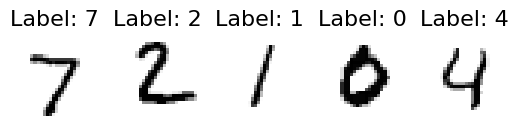

In [6]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)
# X_train, y_train, X_test, y_test = load_MNIST_8(flatten_images=True)

# Display some images
plot_some_imgs(X_test, y_test)

In [7]:
def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batch_size=32, plot_or_not=False,
               loss_func_and_name=(cross_entropy_loss_method, "CE"), #(MSELoss_method, "MSE")
               test_func_and_name=(cross_entropy_loss_method, "CE"), 
               result_filepath=None, store_params=False, intermediate_epochs=None):    
    """
    Performs a training with the given parameters

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function. Also get the accuracy function
    loss_func = jit(loss_func_and_name[0](model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))
    accuracy_func = jit(accuracy_func_method(model))

    # (usually MSE) loss function for evaluation
    if plot_or_not:
        test_func = jit(test_func_and_name[0](model))
    else:
        test_func = None

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, batch_size=batch_size,
                      test_loss_func= test_func, lr=lr, 
                      intermediate_epochs=intermediate_epochs)

    # Plot if wanted ...
    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], ylabel=test_func_and_name[1])

    # Add accuracy scores
    result["test_accuracy"]  = float(accuracy_func(result["beta_final"], X_test, y_test))
    result["train_accuracy"] = float(accuracy_func(result["beta_final"], X_train, y_train))
    # Also store the model for potential later use
    result["model"] = model

    # Store the result to given file
    if result_filepath:

        _dict_to_store =  { "lr"                : lr, 
                            "lam"               : lam,
                            "batch_size"        : batch_size,
                            "hidden_layer_num"  : hidden_layer_num, 
                            "node_per_hidden"   : node_per_hidden, 
                            "hidden_activation" : hidden_activation.__name__,
                            "output_activation" : output_activation.__name__,
                            "loss_function"     : loss_func_and_name[1],
                            "train_num"         : y_train.shape[0],
                            "test_num"          : y_test.shape[0]
                          }
        if store_params:
            _dict_to_store["beta_final"] = {key: value.tolist() for key, value in result["beta_final"].items()}

        # Possibility of storing run with fewer epochs
        if intermediate_epochs is not None:
            for ie, be in zip(intermediate_epochs, result["beta_intermediate"]):
                _dict_to_store = {"test_accuracy"     : float(accuracy_func(be, X_test, y_test)), 
                                  "train_accuracy"    : float(accuracy_func(be, X_train, y_train)),
                                  "epochs"            : ie} | _dict_to_store

                append_run_to_file(result_filepath, _dict_to_store)

        _dict_to_store = {"test_accuracy"     : result["test_accuracy"], 
                          "train_accuracy"    : result["train_accuracy"],
                          "epochs"            : epochs} | _dict_to_store
        append_run_to_file(result_filepath, _dict_to_store)

    return result

## A demonstration
epochs = 10
batch_size = 128 #4096 2048 # 128 # 1024
lr = 0.005 # 0.01
lam = 0.0001
layers = 3
nodes = 100
test_func_and_name = (accuracy_func_method, "Accuracy")

# result = single_run(X_train, X_test, y_train, y_test, 
#                     lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=nn.tanh,
#                     epochs=epochs, batch_size=batch_size, 
#                     plot_or_not=True, test_func_and_name=test_func_and_name,
#                     result_filepath="test.json")

# print("Accuracy test: ", result["test_accuracy"])
# print("Accuracy train: ", result["train_accuracy"])

# print(f"{test_func_and_name[1]} test: ", result["test_loss_list"][-1])
# print(f"{test_func_and_name[1]} train: ", result["train_loss_list"][-1])

# assert(False)

### Architecture

In [11]:
epochs     = 10
lr         = 0.01
batch_size = 128
lam = 0
filepath = "Results/neural_28_sigmoid.json"
hidden_activation=nn.sigmoid

hidden_layer_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8]
hidden_node_nums = [8, 16, 32, 64, 128, 256, 512, 1024] # 784 = size of input layer 
hidden_node_nums.reverse()

for layers in hidden_layer_nums:
    for nodes in hidden_node_nums:

        result = single_run(X_train, X_test, y_train, y_test, 
                        lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=hidden_activation,
                        epochs=epochs, batch_size=batch_size, 
                        plot_or_not=False, result_filepath=filepath)
        print(f"layers: {layers}, nodes: {nodes}, training_acc: {result['train_accuracy']}, test_acc: {result['test_accuracy']}")

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


layers: 0, nodes: 1024, training_acc: 0.9342166781425476, test_acc: 0.925000011920929


100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


layers: 0, nodes: 512, training_acc: 0.9308500289916992, test_acc: 0.9210000038146973


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


layers: 0, nodes: 256, training_acc: 0.9319000244140625, test_acc: 0.9254999756813049


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


layers: 0, nodes: 128, training_acc: 0.9265166521072388, test_acc: 0.9193999767303467


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


layers: 0, nodes: 64, training_acc: 0.9327999949455261, test_acc: 0.9229999780654907


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


layers: 0, nodes: 32, training_acc: 0.9314333200454712, test_acc: 0.9228000044822693


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


layers: 0, nodes: 16, training_acc: 0.9337666630744934, test_acc: 0.9247999787330627


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


layers: 0, nodes: 8, training_acc: 0.9316499829292297, test_acc: 0.9272000193595886


100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


layers: 1, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [00:23<00:00,  2.36s/it]


layers: 1, nodes: 512, training_acc: 0.9944000244140625, test_acc: 0.9771999716758728


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


layers: 1, nodes: 256, training_acc: 0.9925333261489868, test_acc: 0.9747999906539917


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


layers: 1, nodes: 128, training_acc: 0.9946666955947876, test_acc: 0.9754999876022339


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


layers: 1, nodes: 64, training_acc: 0.9907666444778442, test_acc: 0.968999981880188


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


layers: 1, nodes: 32, training_acc: 0.9790999889373779, test_acc: 0.9624999761581421


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


layers: 1, nodes: 16, training_acc: 0.9621333479881287, test_acc: 0.9452999830245972


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


layers: 1, nodes: 8, training_acc: 0.9318833351135254, test_acc: 0.9178000092506409


100%|██████████| 10/10 [02:19<00:00, 13.91s/it]


layers: 2, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


layers: 2, nodes: 512, training_acc: 0.9733333587646484, test_acc: 0.9667999744415283


100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


layers: 2, nodes: 256, training_acc: 0.982366681098938, test_acc: 0.9700000286102295


100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


layers: 2, nodes: 128, training_acc: 0.9869666695594788, test_acc: 0.9692000150680542


100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


layers: 2, nodes: 64, training_acc: 0.9881500005722046, test_acc: 0.9692999720573425


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


layers: 2, nodes: 32, training_acc: 0.9816666841506958, test_acc: 0.9613000154495239


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


layers: 2, nodes: 16, training_acc: 0.9613833427429199, test_acc: 0.9465000033378601


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


layers: 2, nodes: 8, training_acc: 0.9301499724388123, test_acc: 0.9208000302314758


100%|██████████| 10/10 [03:22<00:00, 20.27s/it]


layers: 3, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


layers: 3, nodes: 512, training_acc: 0.9243833422660828, test_acc: 0.9218999743461609


100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


layers: 3, nodes: 256, training_acc: 0.9780666828155518, test_acc: 0.9693999886512756


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


layers: 3, nodes: 128, training_acc: 0.9780666828155518, test_acc: 0.9632999897003174


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


layers: 3, nodes: 64, training_acc: 0.9865999817848206, test_acc: 0.968999981880188


100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


layers: 3, nodes: 32, training_acc: 0.9785000085830688, test_acc: 0.9578999876976013


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


layers: 3, nodes: 16, training_acc: 0.9585666656494141, test_acc: 0.9433000087738037


100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


layers: 3, nodes: 8, training_acc: 0.9303500056266785, test_acc: 0.9168000221252441


100%|██████████| 10/10 [04:18<00:00, 25.84s/it]


layers: 4, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]


layers: 4, nodes: 512, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


layers: 4, nodes: 256, training_acc: 0.8210999965667725, test_acc: 0.8206000328063965


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


layers: 4, nodes: 128, training_acc: 0.9755666851997375, test_acc: 0.9638000130653381


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


layers: 4, nodes: 64, training_acc: 0.9783333539962769, test_acc: 0.9652000069618225


100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


layers: 4, nodes: 32, training_acc: 0.9753833413124084, test_acc: 0.956000030040741


100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


layers: 4, nodes: 16, training_acc: 0.9550166726112366, test_acc: 0.9370999932289124


100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


layers: 4, nodes: 8, training_acc: 0.9306666851043701, test_acc: 0.9182999730110168


100%|██████████| 10/10 [05:19<00:00, 31.93s/it]


layers: 5, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [01:33<00:00,  9.36s/it]


layers: 5, nodes: 512, training_acc: 0.09751665592193604, test_acc: 0.09740002453327179


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]


layers: 5, nodes: 256, training_acc: 0.9196500182151794, test_acc: 0.9153000116348267


100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


layers: 5, nodes: 128, training_acc: 0.9692999720573425, test_acc: 0.9593999981880188


100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


layers: 5, nodes: 64, training_acc: 0.9728166460990906, test_acc: 0.958899974822998


100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


layers: 5, nodes: 32, training_acc: 0.9742666482925415, test_acc: 0.9562000036239624


100%|██████████| 10/10 [00:18<00:00,  1.88s/it]


layers: 5, nodes: 16, training_acc: 0.9507666826248169, test_acc: 0.933899998664856


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


layers: 5, nodes: 8, training_acc: 0.9193666577339172, test_acc: 0.9014000296592712


100%|██████████| 10/10 [06:20<00:00, 38.07s/it]


layers: 6, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [01:51<00:00, 11.11s/it]


layers: 6, nodes: 512, training_acc: 0.09929998964071274, test_acc: 0.1032000258564949


100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


layers: 6, nodes: 256, training_acc: 0.10218331962823868, test_acc: 0.10100002586841583


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


layers: 6, nodes: 128, training_acc: 0.9586833119392395, test_acc: 0.9491000175476074


100%|██████████| 10/10 [00:27<00:00,  2.70s/it]


layers: 6, nodes: 64, training_acc: 0.9650333523750305, test_acc: 0.9509999752044678


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


layers: 6, nodes: 32, training_acc: 0.9699166417121887, test_acc: 0.9532999992370605


100%|██████████| 10/10 [00:21<00:00,  2.13s/it]


layers: 6, nodes: 16, training_acc: 0.9566333293914795, test_acc: 0.9406999945640564


100%|██████████| 10/10 [00:21<00:00,  2.11s/it]


layers: 6, nodes: 8, training_acc: 0.9195500016212463, test_acc: 0.9135000109672546


100%|██████████| 10/10 [07:29<00:00, 44.97s/it]


layers: 7, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [02:09<00:00, 12.91s/it]


layers: 7, nodes: 512, training_acc: 0.11236665397882462, test_acc: 0.11350002139806747


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


layers: 7, nodes: 256, training_acc: 0.8039666414260864, test_acc: 0.8033000230789185


100%|██████████| 10/10 [00:41<00:00,  4.16s/it]


layers: 7, nodes: 128, training_acc: 0.9500333070755005, test_acc: 0.9434999823570251


100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


layers: 7, nodes: 64, training_acc: 0.9599000215530396, test_acc: 0.9506999850273132


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]


layers: 7, nodes: 32, training_acc: 0.9698666930198669, test_acc: 0.9563000202178955


100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


layers: 7, nodes: 16, training_acc: 0.9526666402816772, test_acc: 0.9373999834060669


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


layers: 7, nodes: 8, training_acc: 0.9263499975204468, test_acc: 0.9156000018119812


100%|██████████| 10/10 [08:49<00:00, 52.90s/it]


layers: 8, nodes: 1024, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [02:30<00:00, 15.09s/it]


layers: 8, nodes: 512, training_acc: 0.10218331962823868, test_acc: 0.10100002586841583


100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


layers: 8, nodes: 256, training_acc: 0.09871665388345718, test_acc: 0.09800001978874207


100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


layers: 8, nodes: 128, training_acc: 0.9311833381652832, test_acc: 0.9261999726295471


100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


layers: 8, nodes: 64, training_acc: 0.9534666538238525, test_acc: 0.9490000009536743


100%|██████████| 10/10 [00:29<00:00,  2.99s/it]


layers: 8, nodes: 32, training_acc: 0.9605000019073486, test_acc: 0.946399986743927


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


layers: 8, nodes: 16, training_acc: 0.9467999935150146, test_acc: 0.9334999918937683


100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


layers: 8, nodes: 8, training_acc: 0.9175333380699158, test_acc: 0.9064000248908997


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


layers: 0, nodes: 1024, training_acc: 0.9319499731063843, test_acc: 0.9221000075340271


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


layers: 0, nodes: 512, training_acc: 0.9340999722480774, test_acc: 0.9254999756813049


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


layers: 0, nodes: 256, training_acc: 0.9311166405677795, test_acc: 0.9258000254631042


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


layers: 0, nodes: 128, training_acc: 0.9306166768074036, test_acc: 0.9241999983787537


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


layers: 0, nodes: 64, training_acc: 0.9336333274841309, test_acc: 0.9276999831199646


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


layers: 0, nodes: 32, training_acc: 0.931850016117096, test_acc: 0.9246000051498413


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


layers: 0, nodes: 16, training_acc: 0.9321666955947876, test_acc: 0.9222999811172485


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


layers: 0, nodes: 8, training_acc: 0.9346500039100647, test_acc: 0.9282000064849854


{'Node': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100], 'Layer': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'Accuracy': [0.957099974155426, 0.9617999792098999, 0.9613999724388123, 0.9714000225067139, 0.9635999798774719, 0.9646000266075134, 0.9703999757766724, 0.9664000272750854, 0.9710000157356262, 0.9623000025749207, 0.965499997138977, 0.967199981212616, 0.9627000093460083, 0.9692000150680542, 0.9602000117301941, 0.9587000012397766, 0.9599999785423279, 0.9629999995231628, 0.9617000222206116, 0.9681000113487244, 0.9642000198364258, 0.972100019454956, 0.9674999713897705, 0.964

c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:133: RuntimeWarning: invalid value encountered in divide
  zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]
c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:142: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymins[i], ymaxs[i])
c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project3_FYS_STK4155\Code\plot.py:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


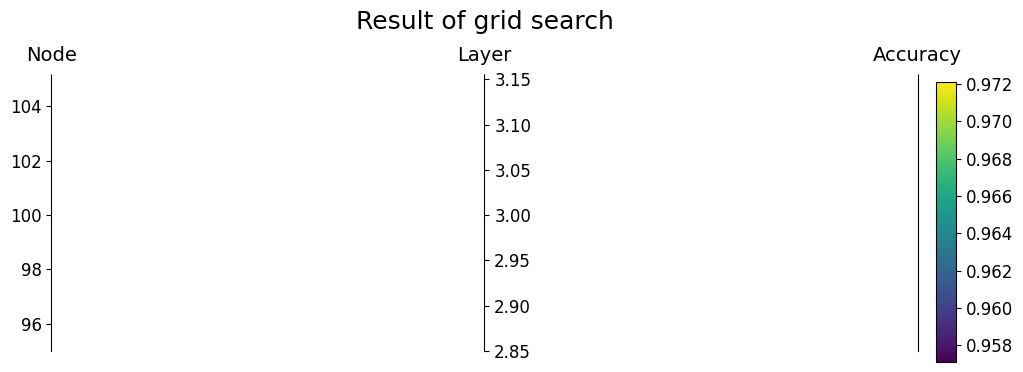

In [ ]:
run_list = load_run_from_file("Results/neural_28.json")


data = {
    # "Epochs": [],
    # "Batch size": [],
    # "Learning rate": [],
    # "Regularisation": [],
    "Node": [],
    "Layer": [],
    "Accuracy": [],
}

for run in run_list:

    if run["test_accuracy"] >= 0:
    
        data["Node"].append(run["node_per_hidden"])
        data["Layer"].append(run["hidden_layer_num"])
        data["Accuracy"].append(run["test_accuracy"])

plot_grid_search_result(data)

nodes per layer: 1


100%|██████████| 300/300 [00:03<00:00, 88.24it/s] 


nodes per layer: 11


 17%|█▋        | 51/300 [00:00<00:03, 71.33it/s]


KeyboardInterrupt: 

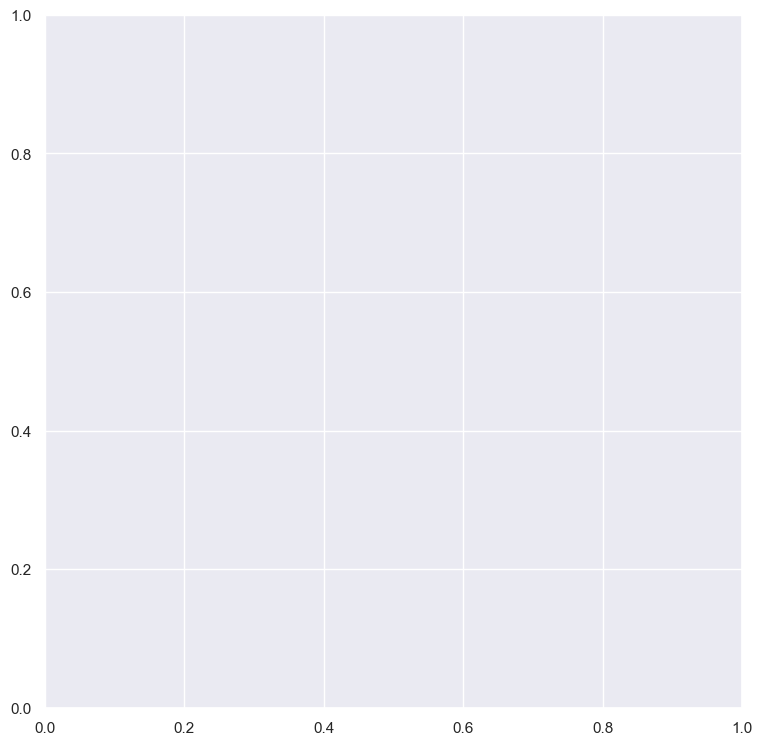

In [ ]:
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    # Maximal number of hidden layers and nodes
    n = 6
    # m = 19
    m = 60
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment_classification.png"

    fig, ax = plt.subplots(figsize=(9, 9))

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, m, m//n)

    # Arrays for storing the errors. temporary result to call result.get
    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    result = {}

    # Loop over nodes per layer
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        
        # Loop over number of hidden layers
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
        
            # Accumulation variables for averaging over nreps
            s_test = 0.0
            s_train = 0.0
        
            # Run nreps times 
            for k in range(nreps):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, 
                                    node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation, 
                                    test_index=result.get("test_index"))
                s_test += result["test_accuracy"]
                s_train += result["train_accuracy"]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    plt.tight_layout()
    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}

_ = hidden_node_hidden_layer_grid(savefig=True, nreps=1)

### Final model evaluation

We make confusion matrix ...

100%|██████████| 40/40 [35:20<00:00, 53.00s/it]


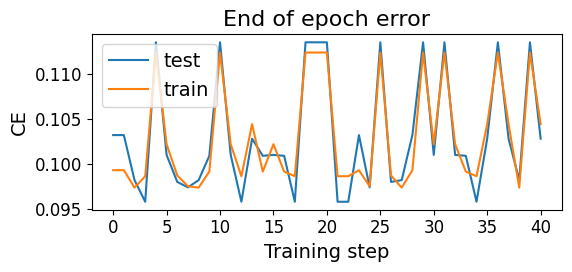

test:  0.10280001908540726
train:  0.10441665351390839
CE test:  0.10280002
CE train:  0.10441665


In [28]:
## A demonstration
epochs = 40
batch_size = 32#64#128 #4096 2048 # 128 # 1024
lr = 0.001 # 0.01
lam = 0.00001

layers = 8
nodes  = 512

result = single_run(X_train, X_test, y_train, y_test, 
                    lr=lr, lam=lam, hidden_layer_num=layers, node_per_hidden=nodes, hidden_activation=nn.sigmoid,
                    epochs=epochs, batch_size=batch_size, 
                    plot_or_not=True, test_func_and_name=(accuracy_func_method, "Accuracy"),
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("CE test: ", result["test_loss_list"][-1])
print("CE train: ", result["train_loss_list"][-1])

model = result["model"]
beta = result["beta_final"]


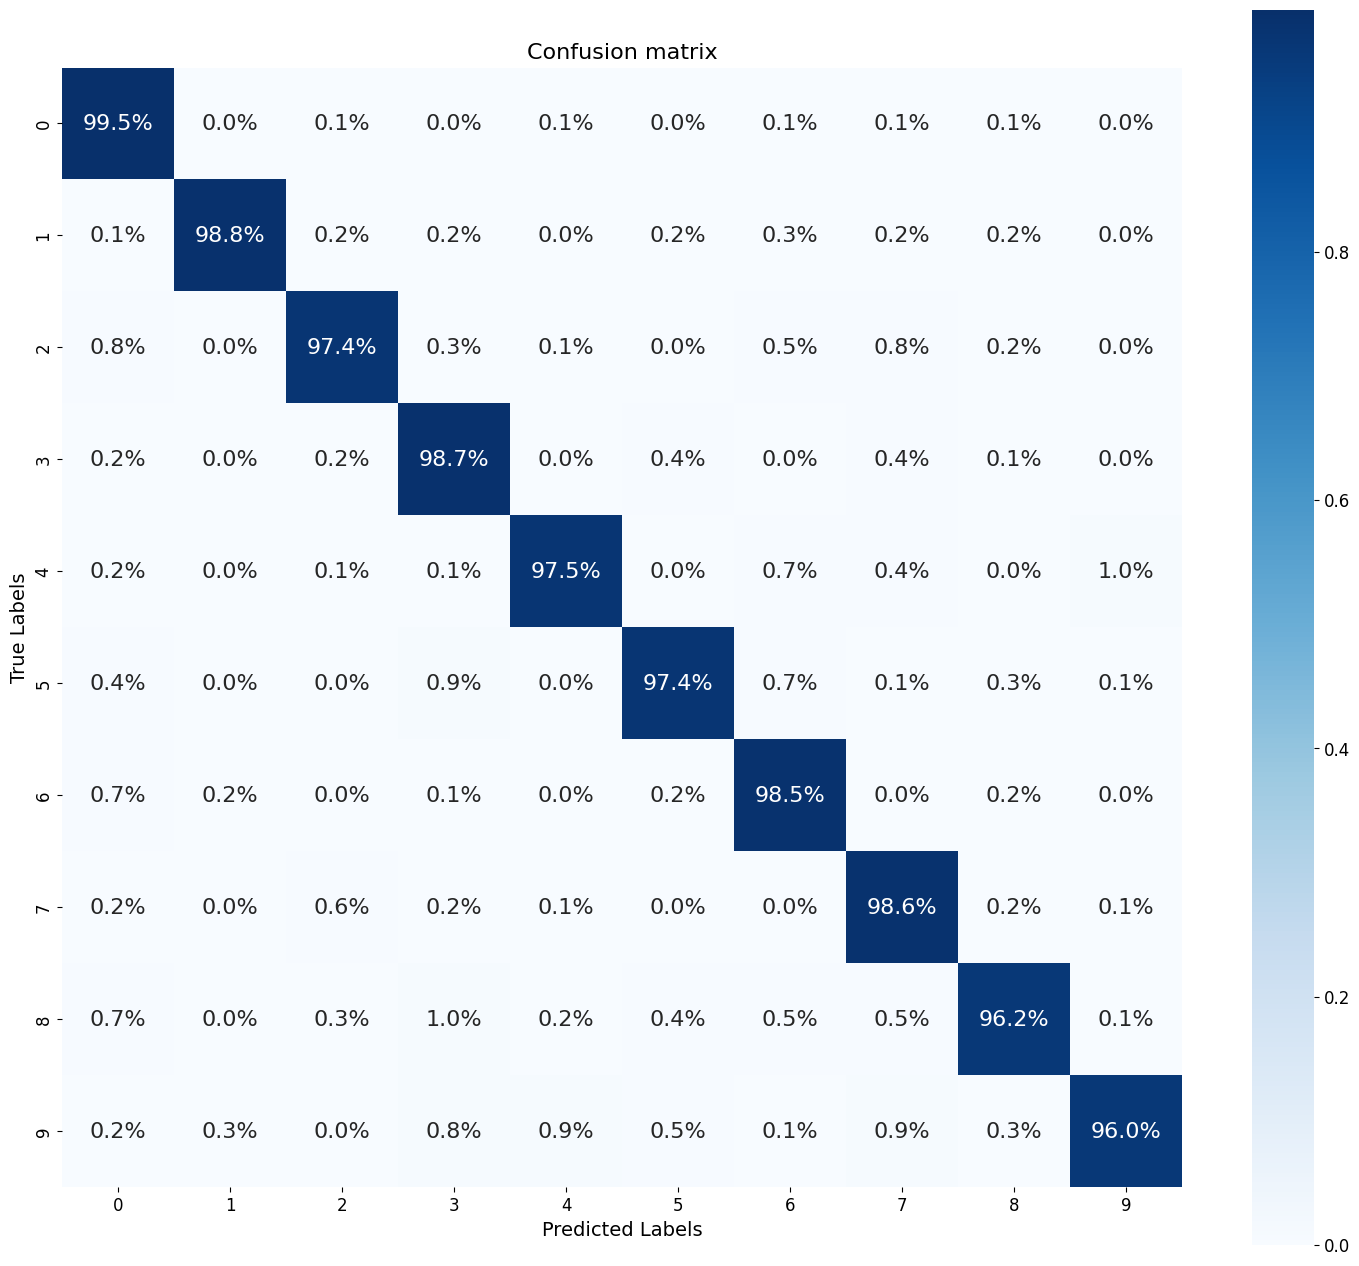

In [7]:
plot_confusion_matrix(X_test, y_test, model, beta, convert_to_percent=True)

Also want to see exactly where the model fails ...

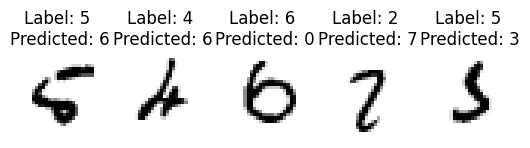

In [8]:
plot_faulty_predictions(X_test, y_test, model, beta)